<a href="https://colab.research.google.com/github/jkarenko/whats-in-my-food/blob/main/What's_in_my_food.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install requirements
!sudo apt install tesseract-ocr
!python -m spacy download en_core_web_lg
!python -m spacy download fi_core_news_lg

In [ ]:
!pip install pytesseract contextualSpellCheck fuzzywuzzy[speedup]

In [ ]:
import pytesseract
import numpy as np
import re
import spacy
import en_core_web_lg
import fi_core_news_lg
import xml.etree.ElementTree as ET
from requests import request
from zipfile import ZipFile
from fuzzywuzzy import process
from io import BytesIO
from PIL import Image, ImageEnhance, ImageFilter
from difflib import get_close_matches
import pandas as pd

In [ ]:
# set the tesseract executable path
pytesseract.pytesseract.tesseract_cmd = r"/usr/bin/tesseract"

In [ ]:
# download trained image-to-text language files
languages = ("fin", "eng")
for lang in languages:
  response = request(method="GET", url=f"https://github.com/tesseract-ocr/tessdata/raw/main/{lang}.traineddata")

  # write the language data as file in tesseract data path
  with open(f"/usr/share/tesseract-ocr/4.00/tessdata/{lang}.traineddata", "wb") as f:
    f.write(response.content)

In [ ]:
# acquire an image for processing
response = request(method="GET", url=r"https://www.dropbox.com/s/vo0nltcnb5q9h71/IMG_0074.jpg?raw=1")

# save image as file
with open("image_original.jpg", "wb") as f:
  f.write(response.content)

In [ ]:
img = Image.open("image_original.jpg")

# calculate new dimensions for image resizing
w: int = 800
h: int = round(img.height * (w / img.width))

# enhance image if needed
img = ImageEnhance.Color(img).enhance(0)
img = ImageEnhance.Contrast(img).enhance(.7)
img = img.filter(ImageFilter.MedianFilter(1))

#resize image
img = img.resize((w, h))

# save image again
img.save(format="jpeg", fp="image_enhanced.jpg")

In [ ]:
config = """ \
--oem 3 \
--psm 1 \
language_model_penalty_non_dict_word=0 \

"""

text = pytesseract.pytesseract.image_to_string(image="image_enhanced.jpg", lang="fin", config=config).strip()
#print(text)

In [ ]:
# set up spacy
nlp = spacy.load("fi_core_news_lg")
doc = nlp(text)
#print({(word, word.pos_) for word in doc})

In [ ]:
nouns = [re.sub(r"[-;:_\(\),./\+\*]", "", token.lemma_.lower()) for token in doc if token.pos_ in ["NOUN", "PROPN", "ADJ"] and len(token.text) > 3]
#print(nouns)

In [ ]:
# download word list
response = request("GET", "https://kaino.kotus.fi/sanat/nykysuomi/kotus-sanalista-v1.zip")
with open("words.zip", "wb") as f:
  f.write(response.content)
with ZipFile("words.zip", "r") as f:
  f.extractall()

In [ ]:
# parse the XML file
tree = ET.parse("kotus-sanalista_v1/kotus-sanalista_v1.xml")
root = tree.getroot()

# extract xml's words as a list
words = {word.text: word.text for word in root.iter("s")}
new_nouns = [words.get(noun, (matches[0] if matches else '')) 
             for noun in nouns 
             for matches in [get_close_matches(word=noun, possibilities=words.keys(), cutoff=.9, n=1)]]
new_nouns = {noun[0] if noun[0] else noun[1] for noun in zip(new_nouns, nouns)}
#print(new_nouns)

In [ ]:
# download Fineli food data CSV
response = request(method="GET", url="https://www.dropbox.com/s/44uq66xyjrpy3xh/food.csv?raw=1")
with open("food.csv", "wb") as f:
  f.write(response.content)

In [ ]:
# load the CSV data into a pandas dataframe
df = pd.read_csv("food.csv", delimiter=";", encoding="iso-8859-1")

# extract food names and types
df['FOODNAME'] = df['FOODNAME'].apply(lambda x: re.sub("[^a-öA-Ö\d\s:]", ",", x.split(",")[0]).lower())
df['IGCLASSP'] = df['IGCLASSP'].apply(lambda x: re.sub("[^a-öA-Ö\d\s:]", "", x.split()[0]).lower())

# create a dictionary mapping 'FOODNAME' to 'IGCLASSP'
ingredient_name_list = {foodname: igclassp for foodname, igclassp in zip(df['FOODNAME'], df['IGCLASSP'])}

#print(ingredient_name_list)
#print({type for type in ingredient_name_list.values()})

Ingredients:
  - sipuli,
  - maltodekstriini,
  - majoneesi,
  - valkopippuri,
  - vesi,
  - kurkku,
  - peruna,
  - perunasalaatti,
  - kananmunankeltuainen,
  - makeutusaine,
  - rypsiöljy

Is vegan: False


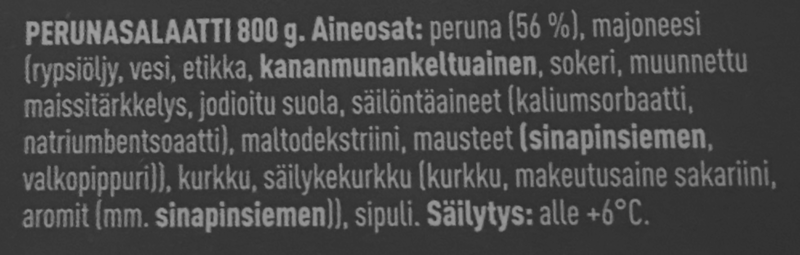

In [ ]:
#final_ingredients = {ingredient: ingredient_name_list[ingredient] for ingredient in new_nouns if ingredient in ingredient_name_list.keys()}
final_ingredients = {ingredient: ingredient_name_list.get(ingredient)
             for ingredient in new_nouns 
             for matches in [get_close_matches(word=ingredient, possibilities=ingredient_name_list.keys(), cutoff=.9, n=1)] if matches}
non_vegan_ingredients = {"meattot", "milktot", "fishtot", "eggtot"}
non_vegan_fats = {"voi", "paistinrasva", "tali", "majoneesi", "rasvaseos", "rasvaseoslevite", "voiöljy"}
is_vegan = not any(ingredient in non_vegan_ingredients for ingredient in final_ingredients.values()) and not any(ingredient in non_vegan_fats for ingredient in final_ingredients.keys())
print("Ingredients:\n  - ", ",\n  - ".join(final_ingredients), sep="", end="\n\n")
print("Is vegan:", is_vegan)
img